In [125]:
#Chargement des bibliothèques nécessaire au nettoyage du Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [66]:
#chargement du dataset 
#dataF = pd.read_csv("../DataSet/en.openfoodfacts.org.products.csv", sep="\t", decimal=".")
dataF = pd.read_csv("../DataSet/cleaned_en.openfoodfacts.org.products.csv", sep=";", decimal=",")

/Users/benjamindeplus/.local/share/virtualenvs/OpenFoodFact-L12SYMG1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,9,13,19,20,21,29,30,36,37,38,39,40,41,44,46,47,48,51,53,54,56,63,75,78,79,80,81,82,83,84,85,86,87,88,89,90,91,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,114,115,116,117,118,119,123,124,126,127,128,133,135,136,141,143,144,145,146,147,148,150,152,154,155,156,157,158,159,160,161,162,163,164,165,167,169,171,172,176,178,179,180,181,182) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
#pour limiter la taille des colonnes nous allons obserbé si certains sont vides. 
#on peut observer le phenomène visuellement
#sns.heatmap(dataF.isnull(), yticklabels = False, cbar = False, cmap="Blues")
#ou plus rapide récuperer les colonnes vides à l'aide d'une simple boucle sur le dataframe

#dataF = dataF.fillna()

empty_cols = [col for col in dataF.columns if dataF[col].isnull().all()]
#Nan_cols = [col for col in dataF.columns if dataF[col].isna()]
print("Nom des colonnes vides", empty_cols)
print("Nombre de colonnes vides", len(empty_cols))

#print(dataF["manganese_100g"].isna().all())
#print(dataF["manganese_100g"].describe())
#print("Nom des colonnes NaN", Nan_cols)
#print("Nombre de colonnes NaN", len(Nan_cols))
#on enlève les colonnes concernés du dataframe
dataF = dataF.drop(columns=list(empty_cols)).sort_index()

Nom des colonnes vides []
Nombre de colonnes vides 0


In [115]:
#evaluate if columns are filled with data or not
nonNullRate = []
for col in dataF.columns: 
    #we are counting the row with data and without Null or NaN over the number of rows
    nonNullRate.append({"columns": col, "rate": round((dataF[col].count()/dataF.shape[0])*100, 3)})
nonNullRateFrame = pd.DataFrame(nonNullRate)    
lessThanOnePercentColumns = nonNullRateFrame[nonNullRateFrame["rate"] < 10]

In [116]:
#list of columns with less than ten % of rows filled
#list(lessThanOnePercentColumns["columns"])
#kill this list of orphane data
cleanDF = dataF.drop(columns=list(lessThanOnePercentColumns["columns"]))

In [118]:
#we just have 66 columns left and 30 with substancial data
cleanDF.shape

(1449815, 66)

In [119]:
#Plusieurs colonnes semblent avoir la même utilité.
#Pour limiter la taille du dataset nous allons cleanés les informations dupliqués 
#created_t, last_modified_t sont des timestamp de leurs homologues voisines qui sont en datetime
#d'autres colonnes sont integralement vide comme additives ingredients_from_palm_oil
cleanDF = cleanDF.drop(columns=["created_t", "last_modified_t"])

In [145]:
cleanDF

,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,packaging,packaging_tags,brands,...,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,8.719200e+12,http://world-en.openfoodfacts.org/product/8719...,openfoodfacts-contributors,21/06/2020 15:50:12,22/06/2020 18:28:27,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.719200e+12,http://world-en.openfoodfacts.org/product/8719...,openfoodfacts-contributors,29/05/2020 13:12:16,01/09/2020 14:32:38,NaN,NaN,NaN,NaN,Becel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.719200e+12,http://world-en.openfoodfacts.org/product/8719...,kiliweb,05/10/2019 07:03:44,10/02/2020 09:47:39,Becel koffiemelk,NaN,NaN,NaN,Becel,...,11.00,NaN,7.10,0.3100,0.124,NaN,NaN,NaN,NaN,NaN
3,8.719200e+12,http://world-en.openfoodfacts.org/product/8719...,kiliweb,30/12/2020 19:41:22,30/12/2020 19:41:23,Flora,NaN,NaN,NaN,NaN,...,1.61,NaN,12.00,18.0000,7.200,NaN,NaN,NaN,NaN,NaN
4,8.719200e+12,http://world-en.openfoodfacts.org/product/8719...,kiliweb,29/01/2020 17:56:16,19/01/2021 10:23:25,Tuli creme,NaN,NaN,NaN,NaN,...,31.00,NaN,2.00,0.5000,0.200,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449810,4.131825e+10,http://world-en.openfoodfacts.org/product/0041...,org-database-usda,23/04/2020 19:03:59,23/04/2020 19:03:59,"Maple bacon flavored wavy potato chips, maple ...",NaN,NaN,NaN,NaN,...,3.57,3.6,7.14,1.6975,0.679,NaN,NaN,0.036,0.00000,13.0
1449811,4.131825e+10,http://world-en.openfoodfacts.org/product/0041...,org-database-usda,23/04/2020 19:03:58,23/04/2020 19:03:58,"Sour cream & onion flavored potato chips, sour...",NaN,NaN,NaN,NaN,...,3.57,3.6,7.14,1.3400,0.536,NaN,NaN,0.071,0.00000,11.0
1449812,4.131825e+10,http://world-en.openfoodfacts.org/product/0041...,org-database-usda,23/04/2020 19:03:59,23/04/2020 19:03:59,"Barbecue flavored potato chips, barbecue",NaN,NaN,NaN,NaN,...,3.57,3.6,7.14,1.3400,0.536,NaN,NaN,0.036,0.00357,11.0
1449813,4.131825e+10,http://world-en.openfoodfacts.org/product/0041...,org-database-usda,23/04/2020 19:01:38,23/04/2020 19:01:38,Artisan garlic parmesan flavored kettle cooked...,NaN,NaN,NaN,NaN,...,7.14,3.6,7.14,1.7850,0.714,NaN,NaN,0.071,0.00000,14.0


<AxesSubplot:>

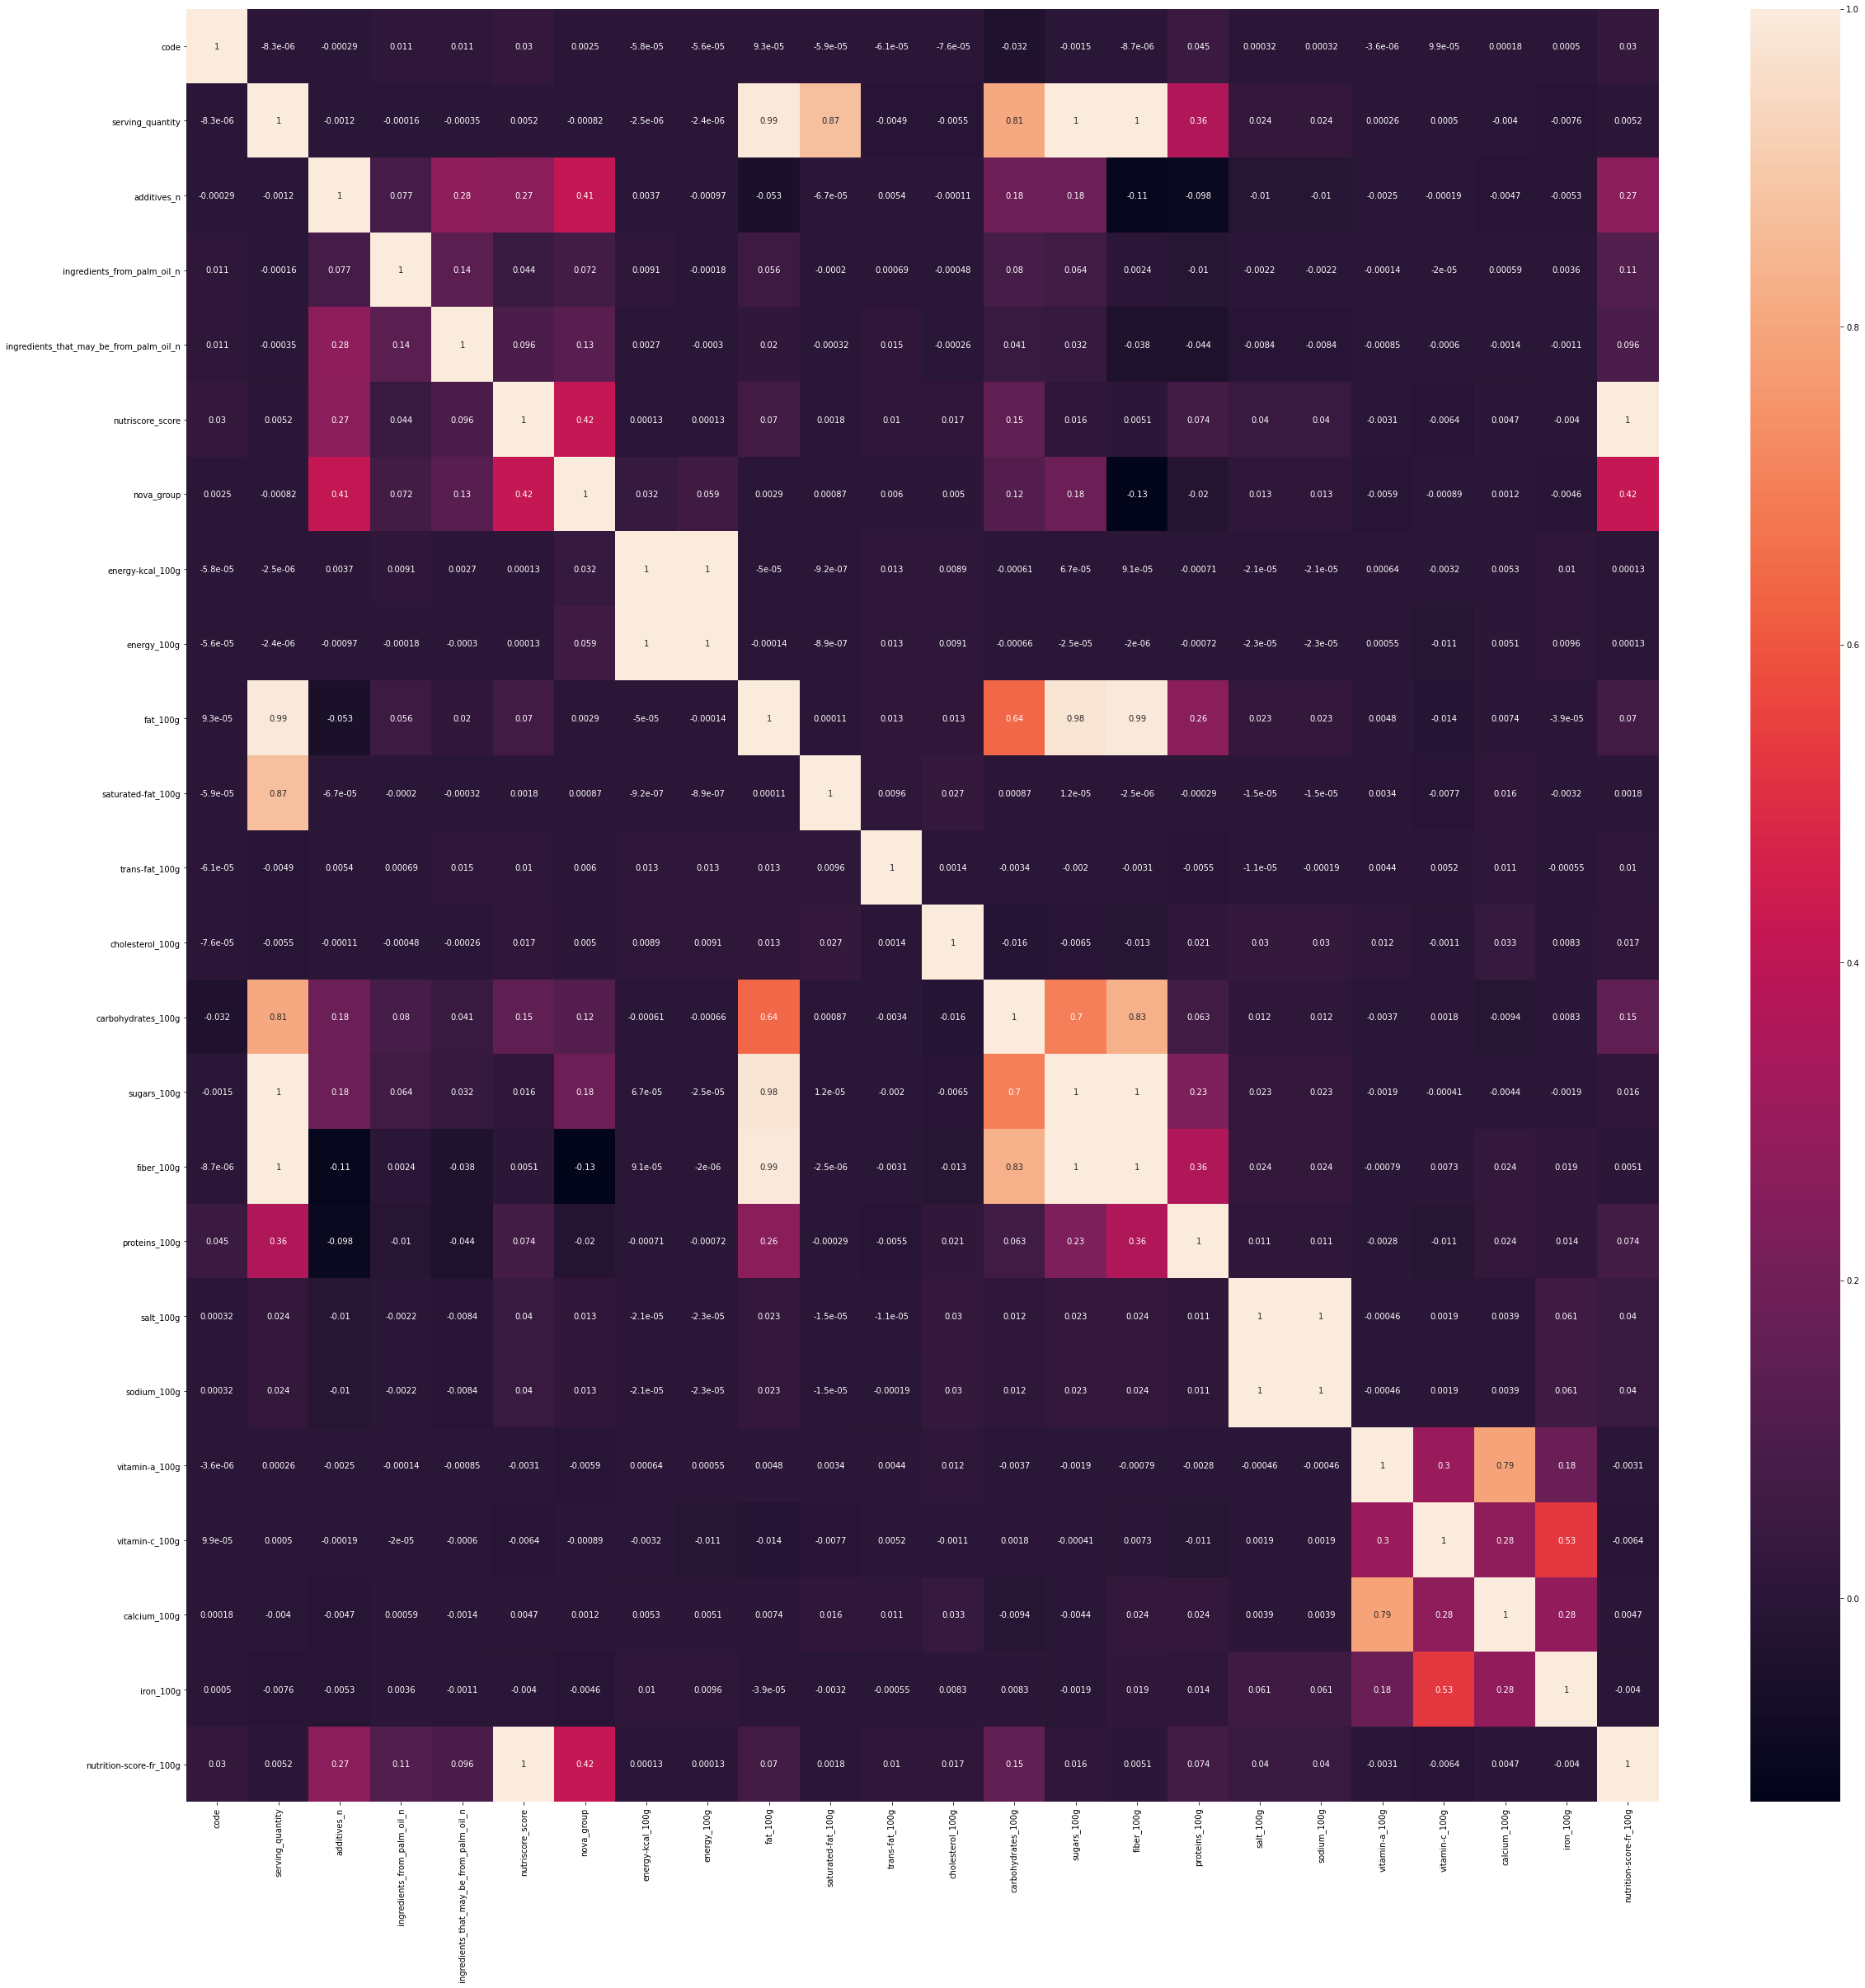

In [127]:
#check correlations 
correlations = cleanDF.corr()
f, ax = plt.subplots(figsize = (40, 40))
sns.heatmap(correlations, annot = True)

In [128]:
#idea recalculate a nutriscore grade from brand with OneHotEncoder and nutritions cars
#pnns_groups_1 and pnns_groups_2 classifier 

In [144]:
#on the contrary let's have a look for very filled column but with limitated values 
#cleanDF.describe
#low distributed columns but highly filled
columns = []
for col in cleanDF.columns: 
    columns.append({"column": col, "nbValues": cleanDF[col].nunique(), "filledRatio": round((cleanDF[col].count()/cleanDF.shape[0])*100, 3)})
toFocusOnColumns = pd.DataFrame(columns)    
#lets Keep Column filled with less than 50 different values 
toFocusOnColumns = toFocusOnColumns[toFocusOnColumns["nbValues"] < 100]
toFocusOnColumns

,column,nbValues,filledRatio
25,additives_n,41,40.869
28,ingredients_from_palm_oil_n,6,40.869
29,ingredients_that_may_be_from_palm_oil_n,7,40.869
30,nutriscore_score,56,38.654
31,nutriscore_grade,5,38.654
32,nova_group,4,35.938
33,pnns_groups_1,15,99.070
34,pnns_groups_2,46,99.941
63,nutrition-score-fr_100g,56,38.654
